# Historical Predictions
This notebook contains the code for the Historical Predictions.

In [2]:
cd ..

/Users/emmaboehly/Documents/Master1/Machine Learning/Projet2/MLProjet2/src


In [3]:
from lib import estimator_util as eu
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [3]:
sns.set_theme()

In [4]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_nominal.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

## All Countries
Historical future and past predictions for all countries.

In [5]:
def all_year_run(complete_df, model, **params):
    countries = complete_df.groupby(["country"]).groups.keys()
    base_year = []
    year_ = []
    r2 = []
    country_ = []
    for country in countries:
        years = complete_df.loc[complete_df["country"] == country].groupby(["year"]).groups.keys()
        for year in years:
            for x_year in years:
                X_base, y_base = eu.get_features(complete_df, [country], [year], all_cols)
                if year == x_year:
                    r, _,_ m = eu.run_model(X_base, y_base, model, **params)
                    country_.append(country)
                    base_year.append(year)
                    year_.append(x_year)
                    r2.append(r)
                    continue
                infl = eu.get_inflation_perf(country, year, x_year)
                X, y = eu.get_features(complete_df, [country], [x_year], all_cols, infl=infl)
                n = len(X_base)
                X = StandardScaler().fit_transform(X)
                r, y_real, y_predicted, m = eu.run_model_out(X_base, y_base, X, y, model, **params)
                country_.append(country)
                base_year.append(year)
                year_.append(x_year)
                r2.append(r)
    return pd.DataFrame.from_dict({"Country": country_,"Train Year": base_year, "Eval Year": year_, "r2": r2})
        

### Prediction with Ridge

In [1]:
all_year_run(complete_df, Ridge, alpha = 1000)

NameError: name 'all_year_run' is not defined

### Prediction with CatBoost

In [ ]:
all_year_run(complete_df, CatBoostRegressor)

## Leave-one-out

In [7]:
def leave_one_out_time_prediction(df, osm_cols, model, **params) :
    countries = ["ETH", "NG"]
    for country in countries:
        print(f"======{country}=====")
        years = list(df.loc[df["country"] == country].groupby(["year"]).groups.keys())
        print(years)
        loo = LeaveOneOut()
        X_ = None
        y_ = None
        for year, x_year in loo.split(years):
            for y in year:
                infl = eu.get_inflation_perf(country, 2010, years[y])
                X_base, y_base = eu.get_features(df, [country], [years[y]], osm_cols, infl)
                
                if X_ is None:
                    X_ = X_base
                else:
                    X_ = np.vstack((X_, X_base))
                
                if y_ is None:
                    y_ = y_base
                else:
                    y_ = np.append(y_, y_base)

            infl = eu.get_inflation_perf(country, 2010, years[x_year[0]])
            X, y = eu.get_features(df, [country], [years[x_year[0]]], osm_cols, infl=infl)
            X_ = StandardScaler().fit_transform(X_)
            X = StandardScaler().fit_transform(X)
            r, y_hest, m = eu.run_model_out(X_, y_, X, y, model, **params)
            print(f"Predicting: {years[x_year[0]]}")
            print(r)

======ETH=====
[2013, 2015, 2018]
Predicting: 2013
0.14668918932095784
Predicting: 2015
0.3520570680989923
Predicting: 2018
0.4032029717255268
======NG=====
[2012, 2015, 2018]
Predicting: 2012
0.09659327580172075
Predicting: 2015
0.5193500466987376
Predicting: 2018
0.6093390853852634


### with Ridge for comparison

In [ ]:
leave_one_out_time_prediction(complete_df, all_cols, Ridge, alpha=1000)

### with CatBoost for best model

In [ ]:
leave_one_out_time_prediction(complete_df, all_cols, CatBoostRegressor)

## Pooled Dataset
Predictions for whole dataset. Consumption is scaled to base year 2010.

In [8]:
def combined_time_travel(df, osm_cols, model, **params) :
    countries = [["NG"], ["ETH"] ,["TZA"], ["MW"], ["NG", "ETH", "TZA", "MW"]]
    results = np.zeros((5,5))
    for i, country in enumerate(countries):
        X, y = eu.get_features_allyears(df, country, osm_cols)
        for j, out_country in enumerate(countries):
            X_out, y_out = eu.get_features_allyears(df,out_country, osm_cols)
            r, _, _, _= eu.run_model_out(X, y, X_out, y_out, model, **params)
            results[i,j] = r

    countries = ["Nigeria", "Ethiopia" ,"Tanzania", "Malawi", "Pooled"]
    df_cm = pd.DataFrame(results, index = countries, columns = countries)
    fig = plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cbar_kws={'label': r'$r^2$'})
    fig.xlabel("Country trained on")
    fig.ylabel("Country evaluated on")
    ax = fig.gca()
    fig.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=ax.transAxes)
    return fig

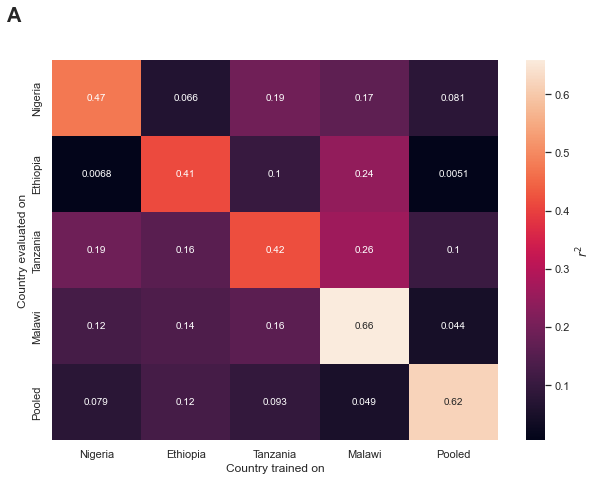

In [9]:
fig = combined_time_travel(complete_df, all_cols, Ridge, alpha=1000)
fig.savefig("../figs/cross_country_pooled_timetravel_ridge.pdf", dpi=600, bbox_inches="tight")

### with CatBoost

In [ ]:
fig = combined_time_travel(complete_df, all_cols, Ridge, alpha=1000)
fig.savefig("../figs/cross_country_pooled_timetravel_catboost.pdf", dpi=600, bbox_inches="tight")

# Plot pooled combined

In [10]:
def plot_pooled_combined_time_travel(complete_df, all_cols, model, **params) :
    country = ["NG", "ETH", "TZA", "MW"]
    X, y = eu.get_features_allyears(complete_df, country, all_cols)
    r, _, m = eu.run_model(X, y, model, **params)
    y_pred = m.predict(X)
    eu.plot_predictions(y, y_pred, r, "Pooled", "Timetravel")

### with Ridge

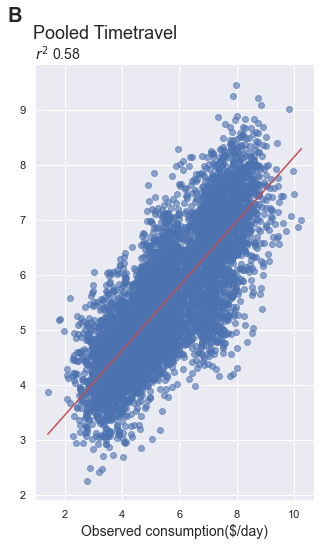

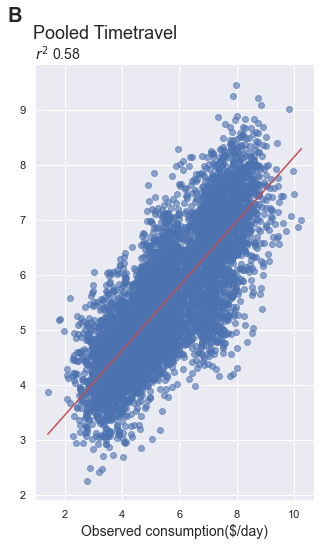

In [11]:
plot_pooled_combined_time_travel(complete_df, all_cols, Ridge, alpha = 1000)

### with CatBoost

In [ ]:
plot_pooled_combined_time_travel(complete_df, all_cols, CatBoostRegressor)